# Proyek Klasifikasi Gambar: **LAMUN**
- **Nama:** [HOLLANDA ARIEF KUSUMA]
- **Email:** [hollandacocobear@gmail.com]
- **ID Dicoding:** [Hollanda]

## 1. Import Semua Packages/Library yang Digunakan

In [ ]:
# Menghubungkan Google Colab dengan Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import library yang dibutuhkan

!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-decision-forests
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback


from sklearn.model_selection import train_test_split
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

!pip install tensorflowjs
import tensorflowjs as tfjs

import numpy as np

# Ekspor requirements.txt
!pip freeze > /content/drive/MyDrive/requirements.txt
!mv /content/drive/MyDrive/requirements.txt /content/drive/MyDrive/Nurul/requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (644.9 MB)
Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboa

## 2. Data Preparation

### A. Data Loading

In [ ]:
# Tentukan direktori dataset di Google Drive untuk training dan testing
#train_dir = '/content/drive/MyDrive/Nurul/DataTrain'  #lokasi folder dataset training
#test_dir = '/content/drive/MyDrive/Nurul/DataTest'  #lokasi folder dataset testing

import os

# Tentukan path folder yang ingin diperiksa
folder_path = '/content/LamunMachineLearningCNN'

# Cek apakah folder sudah ada
if os.path.exists(folder_path):
    print(f"Folder {folder_path} sudah ada. Menghapus folder...")
    # Hapus folder dan isinya
    !rm -rf {folder_path}
else:
    print(f"Folder {folder_path} tidak ditemukan.")

# Clone ulang repositori dari GitHub
!git clone https://github.com/hollandakusuma/LamunMachineLearningCNN.git

train_dir = '/content/LamunMachineLearningCNN/DataTrain'
test_dir = '/content/LamunMachineLearningCNN/DataTest'

# Tentukan direktori untuk masing-masing kelas
classes = ['HoludoleUninervis','SyringodiumIsoetifolium','ThalassiaHemprichi']

# Fungsi untuk memuat data dari direktori
def load_data(base_dir):
    filepaths = []
    labels = []
    folder_image_count = {}

    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        num_images = len(os.listdir(class_dir))
        folder_image_count[class_name] = num_images

        for fname in os.listdir(class_dir):
            fpath = os.path.join(class_dir, fname)
            filepaths.append(fpath)
            labels.append(class_name)

    return filepaths, labels, folder_image_count

# Memuat data training
train_filepaths, train_labels, train_folder_image_count = load_data(train_dir)

# Memuat data testing
test_filepaths, test_labels, test_folder_image_count = load_data(test_dir)

# Tampilkan jumlah gambar di setiap folder training
print("Jumlah gambar di setiap folder Train:")
for class_name, count in train_folder_image_count.items():
    print(f"{class_name}: {count} gambar")

# Tampilkan jumlah gambar di setiap folder testing
print("\nJumlah gambar di setiap folder Test:")
for class_name, count in test_folder_image_count.items():
    print(f"{class_name}: {count} gambar")

# Tampilkan label yang digunakan dalam pengklasifikasian
print("\nLabel yang akan digunakan dalam pengklasifikasian:")
print(classes)

Folder /content/LamunMachineLearningCNN tidak ditemukan.
Cloning into 'LamunMachineLearningCNN'...
remote: Enumerating objects: 2286, done.
remote: Counting objects: 100% (1289/1289), done.
remote: Compressing objects: 100% (1289/1289), done.
remote: Total 2286 (delta 101), reused 0 (delta 0), pack-reused 997 (from 1)
Receiving objects: 100% (2286/2286), 1.29 GiB | 27.73 MiB/s, done.
Resolving deltas: 100% (187/187), done.
Updating files: 100% (2071/2071), done.
Jumlah gambar di setiap folder Train:
HoludoleUninervis: 680 gambar
SyringodiumIsoetifolium: 680 gambar
ThalassiaHemprichi: 680 gambar

Jumlah gambar di setiap folder Test:
HoludoleUninervis: 10 gambar
SyringodiumIsoetifolium: 10 gambar
ThalassiaHemprichi: 10 gambar

Label yang akan digunakan dalam pengklasifikasian:
['HoludoleUninervis', 'SyringodiumIsoetifolium', 'ThalassiaHemprichi']


### B. Data Preprocessing

In [ ]:
def get_unique_images_by_size(base_dir, classes, num_images_per_class=5):
    selected_images = []
    selected_labels = []

    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        size_dict = {}

        for fname in os.listdir(class_dir):
            fpath = os.path.join(class_dir, fname)
            with Image.open(fpath) as img:
                size = img.size

                # Jika ukuran gambar unik, tambahkan ke daftar
                if size not in size_dict:
                    size_dict[size] = fpath
                    selected_labels.append(class_name)

                # Hentikan jika sudah mendapatkan num_images_per_class gambar dengan ukuran unik
                if len(size_dict) >= num_images_per_class:
                    break

        # Tambahkan semua gambar unik yang ditemukan untuk kelas ini ke daftar hasil akhir
        selected_images.extend(size_dict.values())

    return selected_images, selected_labels

# Dapatkan 2 gambar dengan ukuran berbeda dari setiap kelas Training
unique_images, unique_labels = get_unique_images_by_size(train_dir, classes, num_images_per_class=2)

# Tampilkan hasil beserta ukuran gambar
print("Data Training\n")
print("Label, Filepath, dan Ukuran Dimensi Gambar:")
for img, label in zip(unique_images, unique_labels):
    with Image.open(img) as image:
        size = image.size
    print(f"Label: {label}, Filepath: {img}, Ukuran: {size} pixel")

# Dapatkan 2 gambar dengan ukuran berbeda dari setiap kelas Training
unique_images, unique_labels = get_unique_images_by_size(train_dir, classes, num_images_per_class=2)

# Tampilkan hasil beserta ukuran gambar
print("\n\nData Testing")
print("Label, Filepath, dan Ukuran Dimensi Gambar:")
for img, label in zip(unique_images, unique_labels):
    with Image.open(img) as image:
        size = image.size
    print(f"Label: {label}, Filepath: {img}, Ukuran: {size} pixel")




Data Training

Label, Filepath, dan Ukuran Dimensi Gambar:
Label: HoludoleUninervis, Filepath: /content/LamunMachineLearningCNN/DataTrain/HoludoleUninervis/HU (1).jpg, Ukuran: (3000, 4000) pixel
Label: HoludoleUninervis, Filepath: /content/LamunMachineLearningCNN/DataTrain/HoludoleUninervis/HU (17)_contrast_high.jpg, Ukuran: (4000, 3000) pixel
Label: SyringodiumIsoetifolium, Filepath: /content/LamunMachineLearningCNN/DataTrain/SyringodiumIsoetifolium/SI (21)_resize_50.jpg, Ukuran: (1500, 2000) pixel
Label: SyringodiumIsoetifolium, Filepath: /content/LamunMachineLearningCNN/DataTrain/SyringodiumIsoetifolium/SI (2)_brightness_20.jpg, Ukuran: (3000, 4000) pixel
Label: ThalassiaHemprichi, Filepath: /content/LamunMachineLearningCNN/DataTrain/ThalassiaHemprichi/TH (17)_contrast_high.jpg, Ukuran: (341, 699) pixel
Label: ThalassiaHemprichi, Filepath: /content/LamunMachineLearningCNN/DataTrain/ThalassiaHemprichi/TH (20)_shearing.jpg, Ukuran: (243, 408) pixel


Data Testing
Label, Filepath, dan 

In [ ]:
# Mengonversi label ke dalam bentuk numerik
label_to_index = {label: idx for idx, label in enumerate(classes)}
# Check if train_labels already contains numeric labels
if isinstance(train_labels[0], str):  # If train_labels contains strings
    numeric_labels = np.array([label_to_index[label] for label in train_labels])
else:  # If train_labels already contains numeric labels
    numeric_labels = train_labels  # No need to convert
# Membuat ImageDataGenerator untuk preprocessing gambar
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Gabungkan filepaths dari data training dan testing
filepaths = train_filepaths

# Tampilkan informasi dasar tentang data yang telah diproses
print("Data preprocessing selesai: ")
print(f"Total gambar training: {len(filepaths)}")
print(f"Jumlah kelas training: {len(classes)}")

# Loop untuk menampilkan informasi label numerik
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name) # base_dir diganti dengan train_dir
    numeric_label = label_to_index[class_name]
    num_images = len(os.listdir(class_dir))

    # Menampilkan informasi
    print(f"Class: {class_name}; Label numerik: {[numeric_label] * 1}")

Data preprocessing selesai: 
Total gambar training: 2040
Jumlah kelas training: 3
Class: HoludoleUninervis; Label numerik: [0]
Class: SyringodiumIsoetifolium; Label numerik: [1]
Class: ThalassiaHemprichi; Label numerik: [2]


#### C. Split Dataset

In [ ]:
import csv
panjang= 100
lebar = 100
batchSize=64

# Lokasi file hasil
output_csv_path = '/content/drive/MyDrive/Nurul/jumlah_data_per_komposisi.csv'

# List untuk menyimpan hasil
data_split_summary = []

ratios = [60, 70, 80, 90]
generators = {}

for ratio in ratios:
    split_name = f"{int(ratio)}_{int((100-ratio))}"
    print(f"\nSplit Dataset {split_name}%")

    # Recalculate numeric_labels based on the original train_labels
    numeric_labels = np.array([label_to_index[label] for label in train_labels])

    # Split data
    train_files, test_files, train_labels_num, test_labels_num = train_test_split(
        train_filepaths,
        numeric_labels,
        test_size=(100 - ratio)/100,
        random_state=42,
        stratify=numeric_labels
    )

    train_labels_str = [str(label) for label in train_labels_num]
    test_labels_str = [str(label) for label in test_labels_num]

    train_df = pd.DataFrame({'filename': train_files, 'class': train_labels_str})
    test_df = pd.DataFrame({'filename': test_files, 'class': test_labels_str})

    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(panjang, lebar),
        batch_size=batchSize,
        class_mode='sparse',
        color_mode='rgb',
        shuffle=True
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filename',
        y_col='class',
        target_size=(panjang, lebar),
        batch_size=batchSize,
        class_mode='sparse',
        color_mode='rgb',
        shuffle=False
    )

    # Simpan ke dictionary
    generators[split_name] = {
        'train': train_generator,
        'val': val_generator,
        'train_count': len(train_files),
        'val_count': len(test_files)
    }

    # Hitung total dan tampilkan
    total = len(train_files) + len(test_files)
    print(f"Total Gambar: {total}")
    print(f"Train: {len(train_files)} ({(len(train_files)/total)*100:.1f}%)")
    print(f"Test : {len(test_files)} ({(len(test_files)/total)*100:.1f}%)")

    # Tambahkan ke list untuk ditulis ke file
    data_split_summary.append([split_name, len(train_files), len(test_files),total])

# Simpan ke file CSV
with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['komposisi', 'train', 'test','total'])  # Header
    writer.writerows(data_split_summary)

print(f"\n✅ Data jumlah train/test per komposisi disimpan ke: {output_csv_path}")



Split Dataset 60_40%
Found 1224 validated image filenames belonging to 3 classes.
Found 816 validated image filenames belonging to 3 classes.
Total Gambar: 2040
Train: 1224 (60.0%)
Test : 816 (40.0%)

Split Dataset 70_30%
Found 1428 validated image filenames belonging to 3 classes.
Found 612 validated image filenames belonging to 3 classes.
Total Gambar: 2040
Train: 1428 (70.0%)
Test : 612 (30.0%)

Split Dataset 80_20%
Found 1632 validated image filenames belonging to 3 classes.
Found 408 validated image filenames belonging to 3 classes.
Total Gambar: 2040
Train: 1632 (80.0%)
Test : 408 (20.0%)

Split Dataset 90_10%
Found 1836 validated image filenames belonging to 3 classes.
Found 204 validated image filenames belonging to 3 classes.
Total Gambar: 2040
Train: 1836 (90.0%)
Test : 204 (10.0%)

✅ Data jumlah train/test per komposisi disimpan ke: /content/drive/MyDrive/Nurul/jumlah_data_per_komposisi.csv


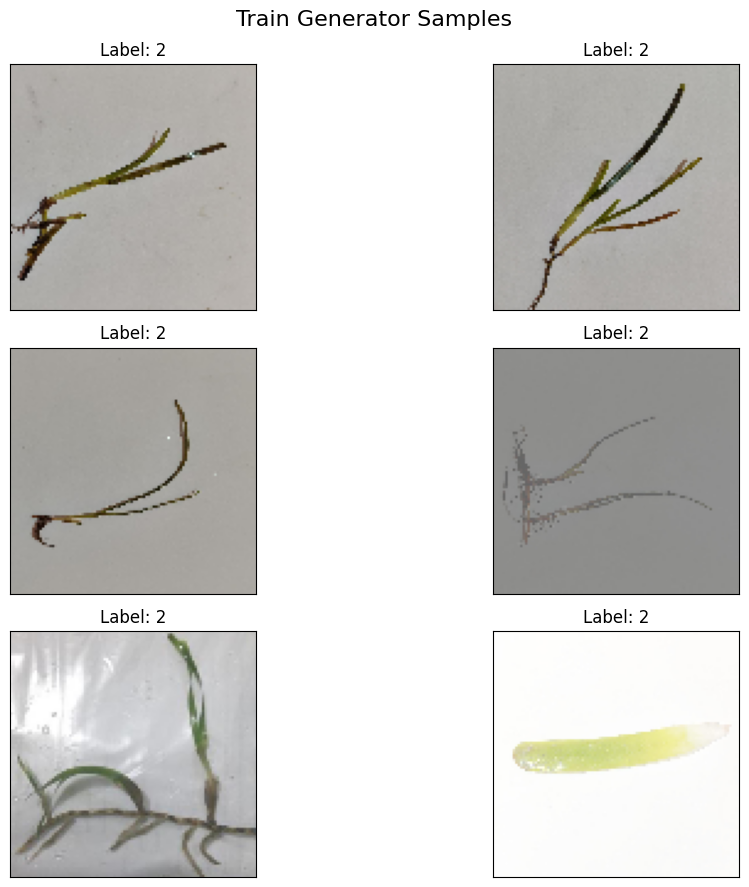

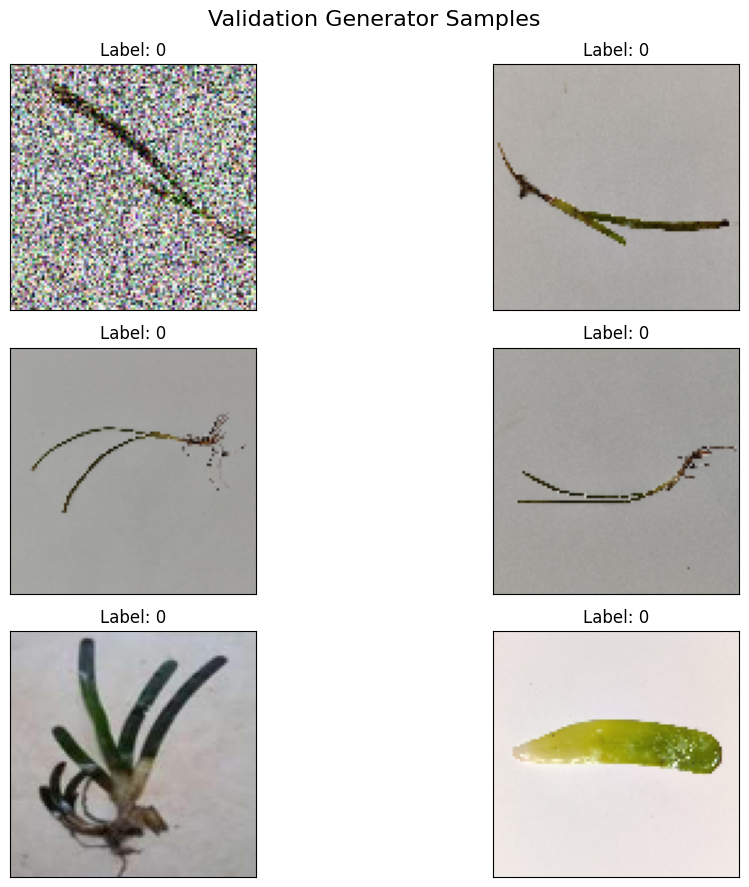

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_images_per_class(generator, classes, title, num_images_per_class=2, save_dir='.'):
    # Create a list of corrected class names for dictionary initialization
    corrected_classes = [c.replace("HoludoleUninervis", "HaloduleUninervis") for c in classes]

    # Menyimpan gambar per kelas
    # Initialize the dictionary with the corrected class names
    images_per_class = {class_name: [] for class_name in corrected_classes}

    # Mengumpulkan gambar untuk setiap kelas
    while any(len(images) < num_images_per_class for images in images_per_class.values()):
        batch = next(generator)
        images, labels = batch

        if labels.dtype == 'float32':
            labels = labels.astype(int)

        for i in range(images.shape[0]):
            label_index = int(labels[i])
            # Get the original label name from the 'classes' list
            original_label_name = classes[label_index]

            # Get the corrected label name to use as the dictionary key
            key_label_name = original_label_name.replace("HoludoleUninervis", "HaloduleUninervis") # Use replace here

            # Ensure the key exists in the dictionary before appending
            if key_label_name in images_per_class and len(images_per_class[key_label_name]) < num_images_per_class:
                images_per_class[key_label_name].append(images[i])

    # Buat ulang daftar kelas dengan nama yang sudah diperbaiki
    # This list is now consistent with the dictionary keys
    cleaned_class_names = list(images_per_class.keys())
    num_classes = len(cleaned_class_names)

    fig, axes = plt.subplots(nrows=num_classes, ncols=num_images_per_class, figsize=(12, num_classes * 3))

    # Flatten axes array for easy iteration if there is only one row
    if num_classes == 1 or num_images_per_class == 1:
         axes = axes.flatten()


    for idx, class_name in enumerate(cleaned_class_names):
        class_images = images_per_class[class_name]
        for i, image in enumerate(class_images):
            # Calculate the correct index for the axes array
            if num_classes > 1 and num_images_per_class > 1:
                ax = axes[idx, i]
            else:
                 ax = axes[idx * num_images_per_class + i]

            ax.imshow(image)
            ax.set_title(f"Label: {list(generator.class_indices.keys())[list(generator.class_indices.values()).index(classes.index(original_label_name))] }") # Show original label from generator
            ax.axis('on')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(False)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Simpan plot ke Google Drive
    save_path = os.path.join(save_dir, f"{title}.png")
    if os.path.exists(save_path):
        os.remove(save_path)
    fig.savefig(save_path)



# Plot gambar dari train_generator
plot_images_per_class(train_generator, classes, "Train Generator Samples", num_images_per_class=2, save_dir='/content/drive/MyDrive/Nurul')

# Plot gambar dari val_generator
plot_images_per_class(val_generator, classes, "Validation Generator Samples", num_images_per_class=2, save_dir='/content/drive/MyDrive/Nurul')

## 3. Modelling

In [ ]:
nilaiDropout = 0.4
nilaiLearningRate=1e-3

# Membangun model CNN
model = Sequential([
    tf.keras.layers.Input(shape=(panjang, lebar, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    #Conv2D(256, (3, 3), activation='relu'),  # Lapisan tambahan
    #MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(nilaiDropout), # Penurunan nilai dropout
    Dense(len(classes), activation='softmax')
])


**Summary Model**

In [ ]:
# Path file tujuan
summary_file_path = "/content/drive/MyDrive/Nurul/model_summary.txt"

# Fungsi untuk mencetak ke console dan menulis ke file
def print_and_save(text, file):
    print(text)
    file.write(text + '\n')

with open(summary_file_path, "w") as f:
    print_and_save("Model Summary:", f)

    # Simpan ringkasan model ke console dan file
    model.summary(print_fn=lambda x: print_and_save(x, f))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=nilaiLearningRate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Tampilkan dan simpan konfigurasi compile model
    print_and_save("\nModel Compilation Configuration:", f)
    print_and_save(f"Optimizer: {model.optimizer.get_config()}", f)
    print_and_save(f"Loss function: {model.loss}", f)
    print_and_save(f"Metrics: {model.metrics_names}", f)

print(f"\n✅ Ringkasan model dan konfigurasi telah disimpan ke: {summary_file_path}")


Model Summary:


Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼─────────────────────

## 4. Evaluasi dan Visualisasi

In [ ]:
akurasi_target = 0.98
jumlahEpoch = 250

# Callback Class
class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= akurasi_target:
            print(f"\nReached {akurasi_target*100:.0f}% validation accuracy, stopping training.")
            self.model.stop_training = True


history_dict = {}
model_dict = {}

# Loop untuk setiap rasio split
for split_name, gen in generators.items():
    print(f"\nLATIH MODEL UNTUK SPLIT {split_name}")
    print(f"Jumlah Epoch = {jumlahEpoch}")

    train_generator = gen['train']
    val_generator = gen['val']

    # Buat callback baru untuk setiap training
    callbacks = [
        StopTrainingCallback(),
        ModelCheckpoint(
            filepath=f'/content/drive/MyDrive/checkpoints/model_{split_name}-{{epoch:02d}}.keras',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            verbose=1,
            mode='min',
            restore_best_weights=True
        )
    ]

    # Latih model
    print("Training Model...")
    history = model.fit(
        train_generator,
        epochs=jumlahEpoch,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    # Simpan history training ke dalam history_dict
    history_dict[split_name] = history
    model_dict[split_name] = model

    # Evaluasi
    print("Evaluasi Model:")
    loss, accuracy = model.evaluate(val_generator, verbose=0)
    print(f"[{split_name}] Loss: {loss:.4f}")
    print(f"[{split_name}] Accuracy: {accuracy:.4f}")



LATIH MODEL UNTUK SPLIT 60_40
Jumlah Epoch = 250
Training Model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.3835 - loss: 1.1313 - val_accuracy: 0.5748 - val_loss: 1.0077
Epoch 2/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.5616 - loss: 0.9089 - val_accuracy: 0.6556 - val_loss: 0.7215
Epoch 3/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.7330 - loss: 0.6358 - val_accuracy: 0.5968 - val_loss: 0.8015
Epoch 4/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.6647 - loss: 0.8068 - val_accuracy: 0.8186 - val_loss: 0.5734
Epoch 5/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.8235 - loss: 0.5111 - val_accuracy: 0.8431 - val_loss: 0.4390
Epoch 6/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.8224 - loss: 0.4499 - val_accuracy: 0.7525 - val_loss: 0.4833
Epoch 7/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.8521 - loss: 0.3777 - val_accuracy: 0.8860 - val_loss: 0.3241
Epoch 8/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.8540 - loss: 0.3599 - val_accuracy: 0.7757 - v

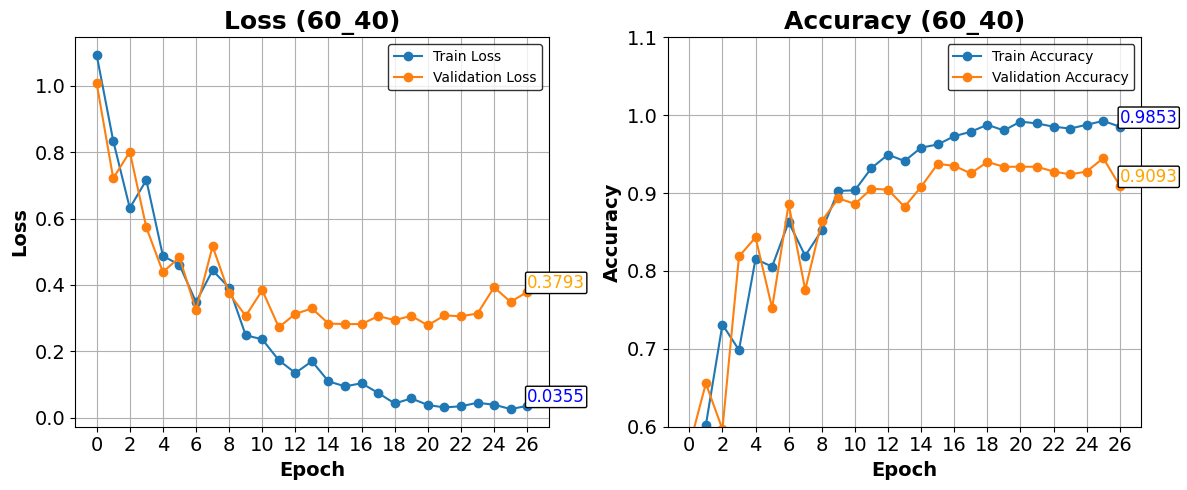

Grafik untuk rasio 60_40 disimpan di: /content/drive/MyDrive/Nurul/Loss_Accuracy_60_40.png


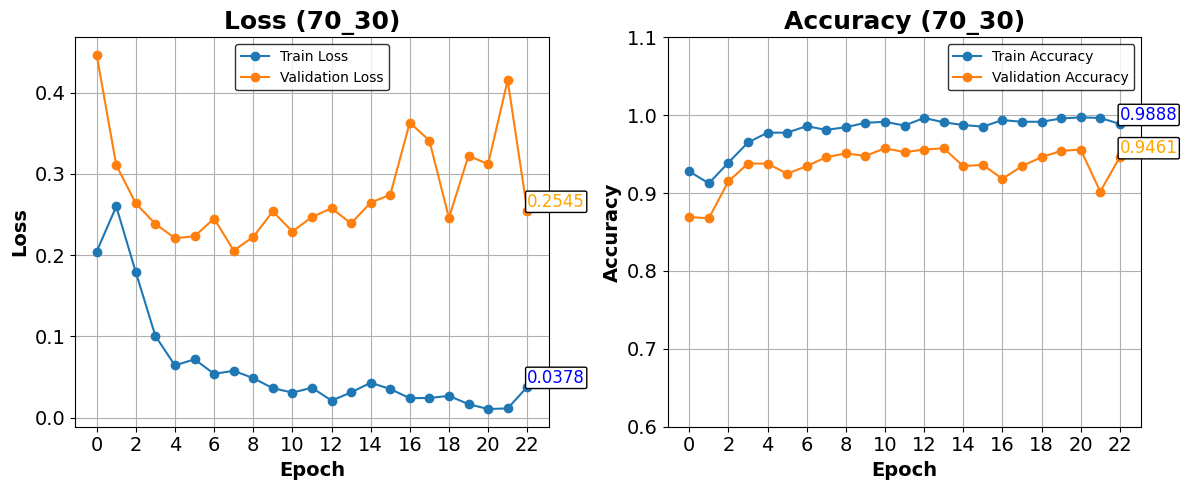

Grafik untuk rasio 70_30 disimpan di: /content/drive/MyDrive/Nurul/Loss_Accuracy_70_30.png


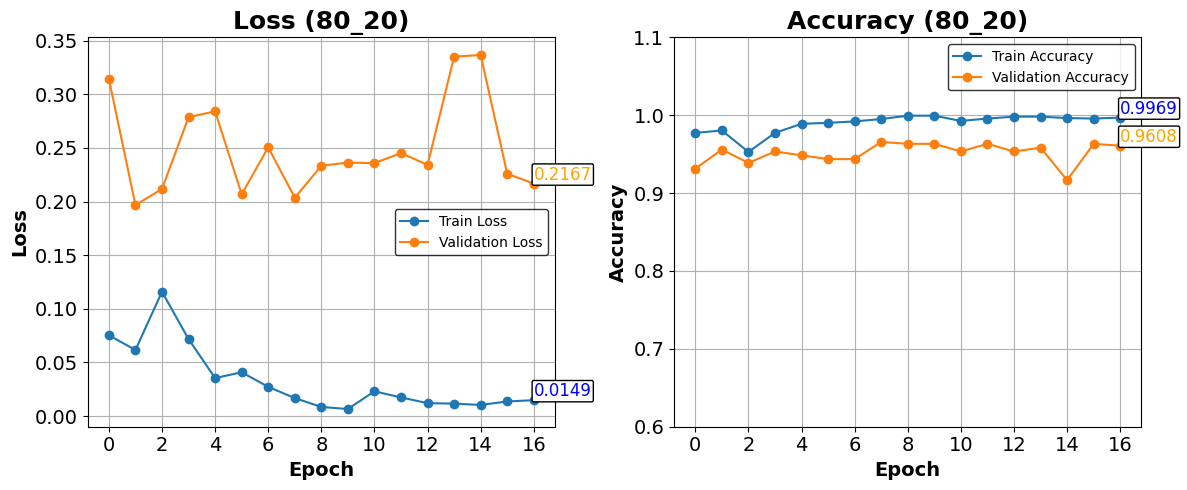

Grafik untuk rasio 80_20 disimpan di: /content/drive/MyDrive/Nurul/Loss_Accuracy_80_20.png


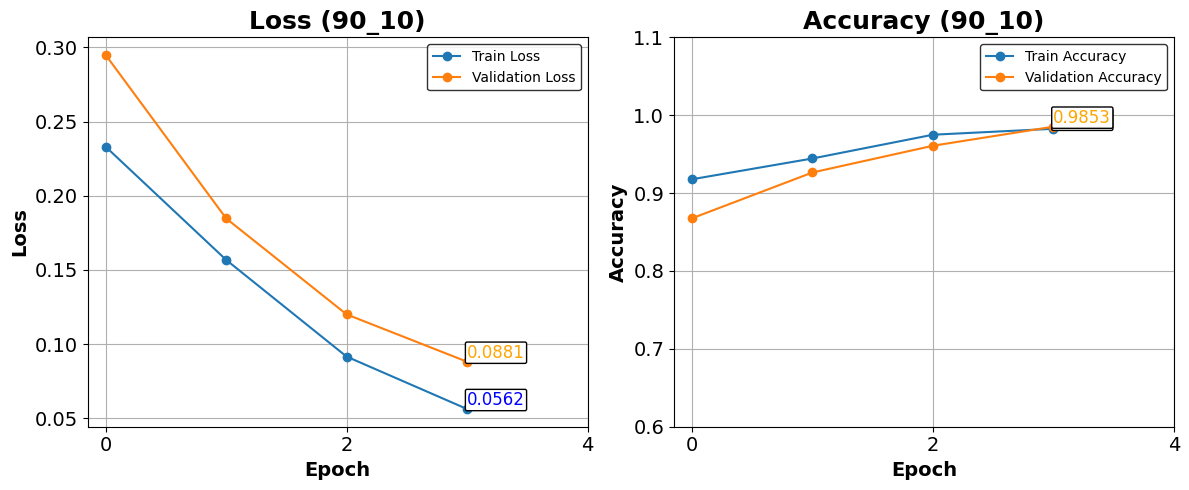

Grafik untuk rasio 90_10 disimpan di: /content/drive/MyDrive/Nurul/Loss_Accuracy_90_10.png


In [ ]:
import matplotlib.pyplot as plt

# Konfigurasi plot
nilaiXTick = 2

# history_dict berisi history dari setiap komposisi data split
# Misalnya: history_dict = {'60:40': history_60, '70:30': history_70, ...}

for rasio, history in history_dict.items():
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'Loss ({rasio})', fontweight='bold', fontsize=18)
    plt.xlabel('Epoch', fontweight='bold', fontsize=14)
    plt.ylabel('Loss', fontweight='bold', fontsize=14)
    plt.xticks(range(0, len(history.history['loss']) + 1, nilaiXTick))
    plt.tick_params(axis='both', labelsize=14)
    plt.grid(True)
    plt.legend(facecolor='white', edgecolor='black')

    # Tambahkan nilai loss akhir
    plt.text(len(history.history['loss']) - 1, history.history['loss'][-1],
             f'{history.history["loss"][-1]:.4f}',
             ha='left', va='bottom', fontsize=12, color='blue',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

    plt.text(len(history.history['val_loss']) - 1, history.history['val_loss'][-1],
             f'{history.history["val_loss"][-1]:.4f}',
             ha='left', va='bottom', fontsize=12, color='orange',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'Accuracy ({rasio})', fontweight='bold', fontsize=18)
    plt.xlabel('Epoch', fontweight='bold', fontsize=14)
    plt.ylabel('Accuracy', fontweight='bold', fontsize=14)
    plt.ylim(0.6, 1.1)
    plt.xticks(range(0, len(history.history['accuracy']) + 1, nilaiXTick))
    plt.tick_params(axis='both', labelsize=14)
    plt.grid(True)
    plt.legend(facecolor='white', edgecolor='black')

    # Tambahkan nilai accuracy akhir
    plt.text(len(history.history['accuracy']) - 1, history.history['accuracy'][-1],
             f'{history.history["accuracy"][-1]:.4f}',
             ha='left', va='bottom', fontsize=12, color='blue',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

    plt.text(len(history.history['val_accuracy']) - 1, history.history['val_accuracy'][-1],
             f'{history.history["val_accuracy"][-1]:.4f}',
             ha='left', va='bottom', fontsize=12, color='orange',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

    plt.tight_layout()
    plt.show()

    # Simpan grafik
    save_path = f'/content/drive/MyDrive/Nurul/Loss_Accuracy_{rasio.replace(":", "-")}.png'
    plt.savefig(save_path)
    plt.close()

    print(f"Grafik untuk rasio {rasio} disimpan di: {save_path}")


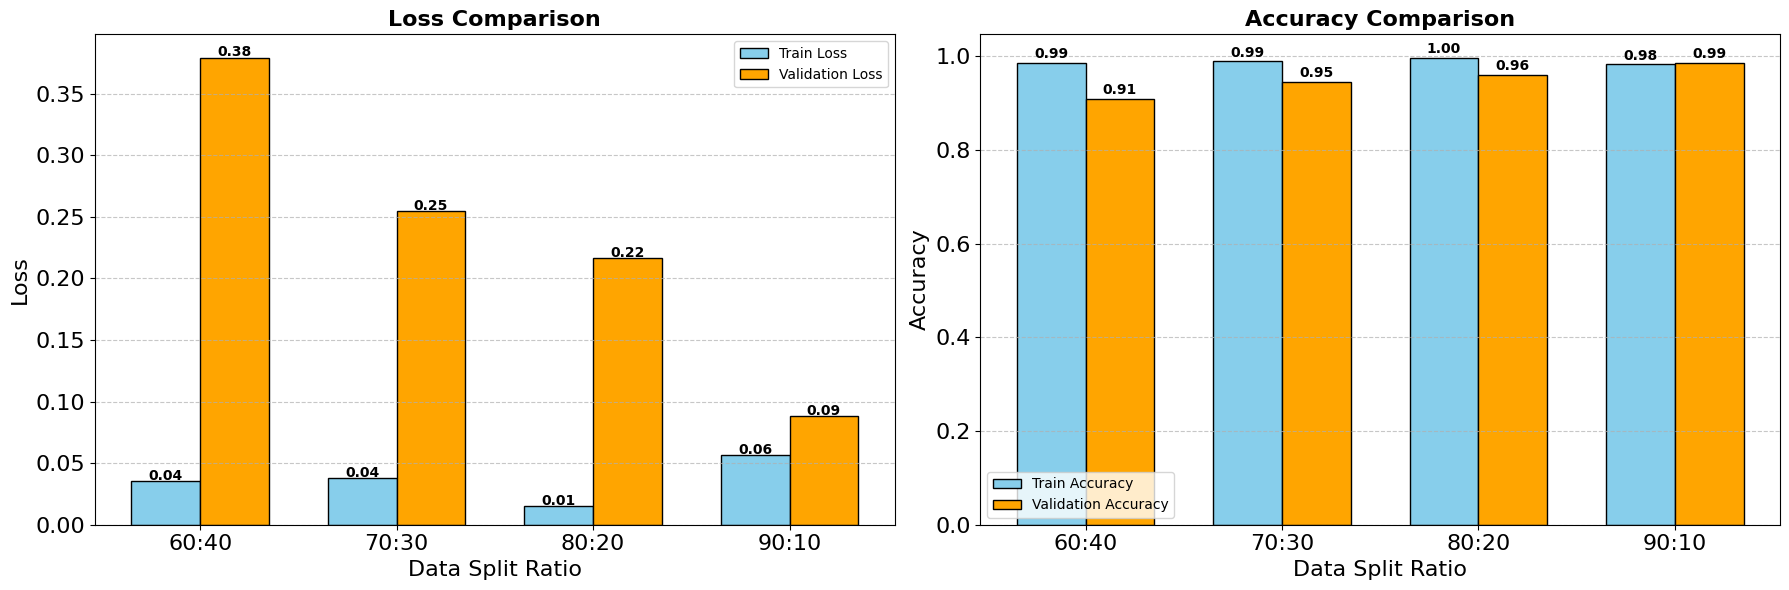

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Assuming history_dict is already populated

# Extract data for plotting
train_loss = []
val_loss = []
train_acc = []
val_acc = []
ratios = []

for rasio, history in history_dict.items():
    ratios.append(rasio)
    train_loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])
    train_acc.append(history.history['accuracy'][-1])
    val_acc.append(history.history['val_accuracy'][-1])

# Adjust ratios for display
ratios = ['60:40', '70:30', '80:20', '90:10']  # Update ratios

# Create subplots with adjusted width
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Set width of bars
bar_width = 0.35

# Plot Loss with side-by-side bars and values on top
x_pos = range(len(ratios))  # Get x positions for bars
axes[0].bar(x_pos, train_loss, bar_width, label='Train Loss', color='skyblue', edgecolor='black')
axes[0].bar([x + bar_width for x in x_pos], val_loss, bar_width, label='Validation Loss', color='orange', edgecolor='black')

# Add values on top of bars
for i, v in enumerate(train_loss):
    axes[0].text(i, v +0.001, f'{v:.2f}', color='black', fontweight='bold', ha='center')
for i, v in enumerate(val_loss):
    axes[0].text(i + bar_width, v+0.001, f'{v:.2f}', color='black', fontweight='bold', ha='center')

axes[0].set_title('Loss Comparison', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Data Split Ratio', fontsize=16)
axes[0].set_ylabel('Loss', fontsize=16)
axes[0].set_xticks([x + bar_width / 2 for x in x_pos])
axes[0].set_xticklabels(ratios)
axes[0].legend()
axes[0].tick_params(axis='both', labelsize=16)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Accuracy with side-by-side bars and values on top
axes[1].bar(x_pos, train_acc, bar_width, label='Train Accuracy', color='skyblue', edgecolor='black')
axes[1].bar([x + bar_width for x in x_pos], val_acc, bar_width, label='Validation Accuracy', color='orange', edgecolor='black')

# Add values on top of bars
for i, v in enumerate(train_acc):
    axes[1].text(i, v + 0.01, f'{v:.2f}', color='black', fontweight='bold', ha='center')
for i, v in enumerate(val_acc):
    axes[1].text(i + bar_width, v + 0.01, f'{v:.2f}', color='black', fontweight='bold', ha='center')

axes[1].set_title('Accuracy Comparison', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Data Split Ratio', fontsize=16)
axes[1].set_ylabel('Accuracy', fontsize=16)
axes[1].set_xticks([x + bar_width / 2 for x in x_pos])
axes[1].set_xticklabels(ratios)
axes[1].legend()
axes[1].tick_params(axis='both', labelsize=16)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Save plot (optional)
plt.savefig('/content/drive/MyDrive/Nurul/Loss_Accuracy_Comparison.png')

## 5. Konversi Model

In [ ]:
import os
import tensorflow as tf
import tensorflowjs as tfjs

# Dictionary model: pastikan Anda punya model_dict = {'60:40': model_60, '70:30': model_70, dst}
# Dictionary classes: list label Anda, misalnya classes = ['HoludoleUninervis', 'Sargassum', 'Ulva']

for rasio, model in model_dict.items():
    rasio_folder = rasio.replace(':', '-')  # contoh: 80:20 → 80-20

    # =================== 1. SavedModel ===================
    saved_model_dir = f'/content/drive/MyDrive/Nurul/saved_model/{rasio_folder}/'
    os.makedirs(saved_model_dir, exist_ok=True)
    tf.saved_model.save(model, saved_model_dir)

    # =================== 2. TensorFlow Lite ===================
    tflite_dir = f'/content/drive/MyDrive/Nurul/tflite/{rasio_folder}/'
    os.makedirs(tflite_dir, exist_ok=True)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(os.path.join(tflite_dir, 'model.tflite'), 'wb') as f:
        f.write(tflite_model)

    # Simpan label untuk TFLite
    with open(os.path.join(tflite_dir, 'label.txt'), 'w') as f:
        for label in classes:
            f.write(f"{label}\n")

    # =================== 3. TensorFlow.js ===================
    tfjs_dir = f'/content/drive/MyDrive/Nurul/tfjs_model/{rasio_folder}/'
    os.makedirs(tfjs_dir, exist_ok=True)
    tfjs.converters.save_keras_model(model, tfjs_dir)

    print(f"Model untuk rasio {rasio} berhasil disimpan ke semua format.")


Saved artifact at '/tmp/tmpnu1f1p_2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132328719620368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719623248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719621712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719622672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719621136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719625360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719626896: TensorSpec(shape=(), dtype=tf.resource, name=None)


failed to lookup keras version from the file,
    this is likely a weight only file
Model untuk rasio 60_40 berhasil disimpan ke semua format.
Saved artifact at '/tmp/tmpeat03jvx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132328719620368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719623248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719621712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719622672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719621136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13232871962

failed to lookup keras version from the file,
    this is likely a weight only file
Model untuk rasio 70_30 berhasil disimpan ke semua format.
Saved artifact at '/tmp/tmp1umojd8v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132328719620368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719623248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719621712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719622672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719621136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13232871962

failed to lookup keras version from the file,
    this is likely a weight only file
Model untuk rasio 80_20 berhasil disimpan ke semua format.
Saved artifact at '/tmp/tmpfu_66fnv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132328719620368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719623248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719621712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719622672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719621136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132328719624976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13232871962

failed to lookup keras version from the file,
    this is likely a weight only file
Model untuk rasio 90_10 berhasil disimpan ke semua format.


## 6. Inference

In [ ]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
import gspread
from google.oauth2.service_account import Credentials
from google.auth.transport.requests import Request

# Direktori folder '_DataUji'
test_dir = '/content/drive/MyDrive/Nurul/DataTest'

# Direktori folder yang berisi model-model tflite
tflite_model_dir = '/content/drive/MyDrive/Nurul/tflite/'

# List nama folder rasio data split
ratios = ['60_40', '70_30', '80_19', '90_9']

# Ubah nama kelas saat mendefinisikan classes
classes = ['HaloduleUninervis', 'SyringodiumIsoetifolium', 'ThalassiaHemprichi']


# Loop melalui setiap rasio data split
all_results = []
accuracy_results = []

# Loop melalui setiap rasio data split
for ratio in ratios:
    # Path lengkap ke model tflite
    model_path = os.path.join(tflite_model_dir, ratio, 'model.tflite')

    # Check if the model file exists
    if not os.path.exists(model_path):
        print(f"Error: Model file not found at {model_path}")
        continue  # Skip to the next ratio if model not found

# Load TensorFlow Lite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensor details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Tentukan ukuran gambar yang diharapkan oleh model
    input_height, input_width = input_details[0]['shape'][1:3]

    # Mengumpulkan gambar, prediksi, dan label sebenarnya
    images_to_plot = []
    predictions_to_plot = []
    actual_labels = []

    # Loop melalui semua subfolder di dalam '_DataUji'
    for class_name in os.listdir(test_dir):
        class_dir = os.path.join(test_dir, class_name)
        if os.path.isdir(class_dir):
            for fname in os.listdir(class_dir):
                fpath = os.path.join(class_dir, fname)
                if os.path.isfile(fpath):
                    # Membaca dan memproses gambar
                    img = Image.open(fpath).resize((input_width, input_height)).convert('RGB')
                    input_data = np.expand_dims(np.array(img) / 255.0, axis=0).astype(np.float32)

                    # Lakukan inferensi
                    interpreter.set_tensor(input_details[0]['index'], input_data)
                    interpreter.invoke()
                    output_data = interpreter.get_tensor(output_details[0]['index'])
                    predicted_class = np.argmax(output_data)

                    # Simpan data
                    images_to_plot.append(img)
                    # Ganti nama kelas jika diperlukan saat menyimpan prediksi
                    predicted_label = classes[predicted_class]
                    if predicted_label == "HoludoleUninervis":
                        predicted_label = "HaloduleUninervis"
                    predictions_to_plot.append(predicted_label)

                    # Ganti nama kelas jika diperlukan saat menyimpan label sebenarnya
                    actual_label = class_name.replace("_", "")
                    if actual_label == "HoludoleUninervis":
                        actual_label = "HaloduleUninervis"
                    actual_labels.append(actual_label)


    # Simpan data ke dalam list all_results
    for i in range(len(images_to_plot)):
        result = [ratio, actual_labels[i].replace("_", ""), predictions_to_plot[i],
                  "Sesuai" if actual_labels[i].replace("_", "") == predictions_to_plot[i] else "Tidak Sesuai"]
        all_results.append(result)

    # Evaluasi dan tampilkan hasil untuk model ini
    correct_predictions = 0
    total_predictions = len(images_to_plot)
    for i in range(len(images_to_plot)):
        print(f"Model: {ratio}, Gambar {i+1}:")
        print(f"  Label Sebenarnya: {actual_labels[i]}")
        print(f"  Prediksi: {predictions_to_plot[i]}")
        if actual_labels[i] == predictions_to_plot[i]:
            correct_predictions += 1
        print(f"  Hasil: {'Sesuai' if actual_labels[i] == predictions_to_plot[i] else 'Tidak Sesuai'}\n")

    accuracy = correct_predictions / total_predictions
    print(f"Model: {ratio}, Akurasi: {accuracy * 100:.2f}%\n")

    # Simpan data akurasi ke dalam list accuracy_results
    accuracy_results.append([ratio, accuracy * 100])

# Create a pandas DataFrame for inference results
results_df = pd.DataFrame(all_results, columns=['Model', 'Label Sebenarnya', 'Prediksi', 'Hasil'])

# Create a pandas DataFrame for accuracy results
accuracy_df = pd.DataFrame(accuracy_results, columns=['Model', 'Akurasi (%)'])

# Display the tables
print("Hasil Inferensi:")
display(results_df)  # Use display for better formatting in Jupyter Notebook

print("\nAkurasi Model:")
display(accuracy_df)

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Model: 60_40, Gambar 1:
  Label Sebenarnya: HaloduleUninervis
  Prediksi: HaloduleUninervis
  Hasil: Sesuai

Model: 60_40, Gambar 2:
  Label Sebenarnya: HaloduleUninervis
  Prediksi: HaloduleUninervis
  Hasil: Sesuai

Model: 60_40, Gambar 3:
  Label Sebenarnya: HaloduleUninervis
  Prediksi: HaloduleUninervis
  Hasil: Sesuai

Model: 60_40, Gambar 4:
  Label Sebenarnya: HaloduleUninervis
  Prediksi: HaloduleUninervis
  Hasil: Sesuai

Model: 60_40, Gambar 5:
  Label Sebenarnya: HaloduleUninervis
  Prediksi: SyringodiumIsoetifolium
  Hasil: Tidak Sesuai

Model: 60_40, Gambar 6:
  Label Sebenarnya: HaloduleUninervis
  Prediksi: HaloduleUninervis
  Hasil: Sesuai

Model: 60_40, Gambar 7:
  Label Sebenarnya: HaloduleUninervis
  Prediksi: SyringodiumIsoetifolium
  Hasil: Tidak Sesuai

Model: 60_40, Gambar 8:
  Label Sebenarnya: HaloduleUninervis
  Prediksi: HaloduleUninervis
  Hasil: Sesuai

Model: 60_40, Gambar 9:
  Label Sebenarnya: HaloduleUninervis
  Prediksi: HaloduleUninervis
  Hasil: Ses

,Model,Label Sebenarnya,Prediksi,Hasil
0,60_40,HaloduleUninervis,HaloduleUninervis,Sesuai
1,60_40,HaloduleUninervis,HaloduleUninervis,Sesuai
2,60_40,HaloduleUninervis,HaloduleUninervis,Sesuai
3,60_40,HaloduleUninervis,HaloduleUninervis,Sesuai
4,60_40,HaloduleUninervis,SyringodiumIsoetifolium,Tidak Sesuai
...,...,...,...,...
115,90_9,ThalassiaHemprichi,HaloduleUninervis,Tidak Sesuai
116,90_9,ThalassiaHemprichi,ThalassiaHemprichi,Sesuai
117,90_9,ThalassiaHemprichi,ThalassiaHemprichi,Sesuai
118,90_9,ThalassiaHemprichi,ThalassiaHemprichi,Sesuai



Akurasi Model:


,Model,Akurasi (%)
0,60_40,90.000000
1,70_30,90.000000
2,80_19,86.666667
3,90_9,86.666667


In [ ]:
# Direktori untuk data uji, model, dan hasil
test_dir = '/content/drive/MyDrive/Nurul/DataTest'
tflite_model_dir = '/content/drive/MyDrive/Nurul/tflite/'
ratios = ['60_40', '70_30', '80_20', '90_10']  # 4 model

all_results = []
accuracy_results = []

for ratio in ratios:

  # Menampilkan gambar asli dan hasil prediksi
  num_images = len(images_to_plot)
  num_cols = 3  # Jumlah kolom untuk subplot (gambar asli dan prediksi)
  num_rows = (num_images + num_cols - 1) // num_cols  # Jumlah baris yang dibutuhkan

  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 4))
  fig.suptitle(f"Hasil Prediksi Gambar - Model {ratio}", fontsize=16, fontweight='bold',y=0.95)

  # Meratakan axes jika hanya ada satu baris
  if num_rows == 1:
      axes = axes.reshape(1, -1)

  for i, (img, true_label, pred_label) in enumerate(zip(images_to_plot, actual_labels, predictions_to_plot)):
      row = i // num_cols
      col = i % num_cols
      ax = axes[row, col]

      # Menampilkan gambar dengan penggantian nama kelas di judul
      displayed_true_label = true_label  # Inisialisasi dengan true_label asli
      if displayed_true_label == "HoludoleUninervis":
          displayed_true_label = "HaloduleUninervis"  # Ganti nama jika diperlukan

      # Menampilkan gambar asli
      ax.imshow(img)
      ax.set_title(f"Label Training: {displayed_true_label}", fontsize=12)
      ax.axis('on')
      # Hilangkan angka dan label sumbu
      ax.set_xticks([])
      ax.set_yticks([])
      # Hilangkan grid
      ax.grid(False)

      # Menampilkan hasil prediksi dengan penggantian nama kelas
      displayed_pred_label = pred_label  # Inisialisasi dengan pred_label asli
      if displayed_pred_label == "HoludoleUninervis":
          displayed_pred_label = "HaloduleUninervis"  # Ganti nama jika diperlukan

      # Menampilkan hasil prediksi
      text_x = 0.5  # Posisi teks horizontal
      text_y = 0.9 if true_label == pred_label else 0.1  # Posisi teks vertikal
      text_color = 'green' if true_label == pred_label else 'red'  # Warna teks
      ax.text(text_x, text_y, f'Prediksi: {pred_label}', fontsize=12, ha='center', va='center', color=text_color, transform=ax.transAxes)
    #ax.text(0.5, 0.4, f'Perbandingan: {"Sesuai" if true_label == pred_label else "Tidak Sesuai"}', fontsize=12, ha='center')  # Dihapus


  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Menyesuaikan tata letak
  plt.savefig(f'/content/drive/MyDrive/Nurul/hasil_prediksi_{ratio}.png')  # Simpan dengan nama model
  plt.show()
  plt.close()

